# T<sub>2</sub> Hahn Characterization

The purpose of the $T_2$ Hahn Echo experiment is to determine $T_2$ qubit property. 

In this experiment, we would like to get a more precise estimate of the qubit's decay time. $T_2$ represents the amount of time required for the transverse magnetization to fall to approximately 37% ($\frac{1}{e}$) of its initial value.

Since the qubit exposed to other noises (like $T_1$), we are using a Rx pulse for decoupling and to solve our inaccuracy for the qubit frequncy estimation.

In [1]:
import qiskit
from qiskit.utils import apply_prefix
from qiskit_experiments.library.characterization.t2hahn import T2Hahn

The circuit used for the experiment comprises the following:

    1. Rx gate
    2. delay
    3. measurement

The user provides as input a series of delays and the time unit for the delays, e.g., seconds, milliseconds, etc. During the delay, we expect the qubit to precess about the z-axis. Because of the echo gate ($Rx(\pi)$) for each echo, the angle will converge after the delay gates as following $\theta_{new} = \theta_{old} + \pi. By varying the extension of the delays, we get a series of decaying measurments. We can draw the graph of the resulting function, and can analytically extract the desired values.

In [16]:
# set the computation units to microseconds
unit = "us"  # microseconds
qubit = 0
# set the desired delays
conversion_factor = 1e-6
delays = list(range(1, 50, 1) )
delays = [float(_) * conversion_factor for _ in delays]

In [17]:
# Create a T2Ramsey experiment. Print the first circuit as an example
exp1 = T2Hahn(qubit, delays)
print(exp1.circuits()[0])

     ┌─────────┐┌─────────────────┐┌───────┐┌─────────────────┐┌─────────┐┌─┐
q_0: ┤ Rx(π/2) ├┤ Delay(1e-06[s]) ├┤ Rx(π) ├┤ Delay(1e-06[s]) ├┤ Rx(π/2) ├┤M├
     └─────────┘└─────────────────┘└───────┘└─────────────────┘└─────────┘└╥┘
c: 1/══════════════════════════════════════════════════════════════════════╩═
                                                                           0 


We run the experiment on a simple, simulated backend, created specifically for this experiment's tutorial.

In [18]:
from qiskit_experiments.test.t2hahn_backend import T2HahnBackend
# FakeJob is a wrapper for the backend, to give it the form of a job
from qiskit_experiments.test.utils import FakeJob


estimated_t2hahn = 20
# The behavior of the backend is determined by the following parameters
backend = T2HahnBackend(
    t2hahn=[20],
    frequency=[100100],
    initialization_error=[0.0],
    readout0to1=[0.02],
    readout1to0=[0.02],
    conversion_factor=conversion_factor,
)

The resulting graph will have the form:
$f(t) = a \cdot e^{-t/T_2}+ b$
where *t* is the delay and $T_2$ is the decay factor.
`conversion_factor` is a scaling factor that depends on the measurement units used. It is 1E-6 here, because the unit is microseconds.

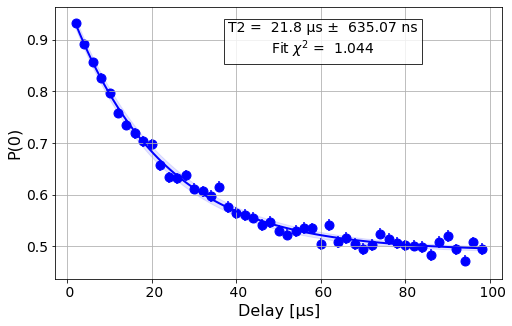

In [24]:
dt_factor = apply_prefix(1, unit)
expdata1 = exp1.run(backend=backend, shots=2000)
expdata1.block_for_results()  # Wait for job/analysis to finish.

# Display the figure
display(expdata1.figure(0))

In [26]:
# Print results
for result in expdata1.analysis_results():
    print(result)

DbAnalysisResultV1
- name: @Parameters_T2HahnAnalysis
- value: [4.80948315e-01 4.91279801e-01 2.17599437e-05] ± [4.99342220e-03 3.32804486e-03 6.35068642e-07]
- χ²: 1.0442511540259622
- quality: good
- extra: <4 items>
- device_components: ['Q0']
- verified: False
DbAnalysisResultV1
- name: T2
- value: 2.1759943722224376e-05 ± 6.350686415844018e-07 s
- χ²: 1.0442511540259622
- quality: good
- device_components: ['Q0']
- verified: False


Additional fitter result data is stored in the `result.extra` field

In [28]:
expdata1.analysis_results("T2").extra

{}

### Providing initial user estimates
The user can provide initial estimates for the parameters to help the analysis process. Because the curve is expected to decay toward $0.5$, the natural choice for parameters $A$ and $B$ is $0.5$.In this experiment, `t2hahn` is the parameter of interest. Good estimate for it is the value computed in previous experiments on this qubit or a similar values computed for other qubits.

In [29]:
print(delays)

[1e-06, 2e-06, 3e-06, 4e-06, 4.9999999999999996e-06, 6e-06, 7e-06, 8e-06, 9e-06, 9.999999999999999e-06, 1.1e-05, 1.2e-05, 1.3e-05, 1.4e-05, 1.4999999999999999e-05, 1.6e-05, 1.7e-05, 1.8e-05, 1.8999999999999998e-05, 1.9999999999999998e-05, 2.1e-05, 2.2e-05, 2.3e-05, 2.4e-05, 2.4999999999999998e-05, 2.6e-05, 2.7e-05, 2.8e-05, 2.9e-05, 2.9999999999999997e-05, 3.1e-05, 3.2e-05, 3.2999999999999996e-05, 3.4e-05, 3.5e-05, 3.6e-05, 3.7e-05, 3.7999999999999995e-05, 3.9e-05, 3.9999999999999996e-05, 4.1e-05, 4.2e-05, 4.2999999999999995e-05, 4.4e-05, 4.4999999999999996e-05, 4.6e-05, 4.7e-05, 4.8e-05, 4.9e-05]


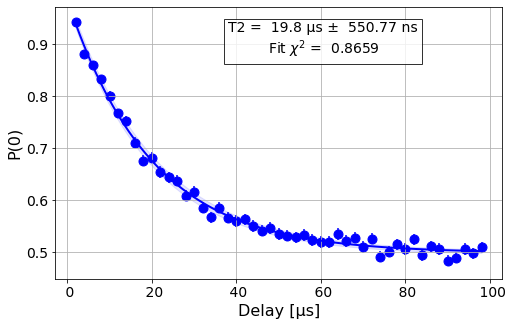

In [30]:
from qiskit_experiments.library.characterization import T2RamseyAnalysis
user_p0 = {"amp": 0.5, "tau": 20 * conversion_factor, "base": 0.5}

exp_with_p0 = T2Hahn(qubit, delays)
exp_with_p0.set_analysis_options(p0={"amp": 0.5, "tau": 20 * conversion_factor, "base": 0.5})
expdata_with_p0 = exp_with_p0.run(backend=backend, shots=2000)
expdata_with_p0.block_for_results()

# Display fit figure
display(expdata_with_p0.figure(0))

In [31]:
# Create a T2Ramsey experiment. Print the first circuit as an example
# exp_with_p0 = T2Hahn(qubit, delays)
# print(exp_with_p0.circuits()[0])
print(delays)

[1e-06, 2e-06, 3e-06, 4e-06, 4.9999999999999996e-06, 6e-06, 7e-06, 8e-06, 9e-06, 9.999999999999999e-06, 1.1e-05, 1.2e-05, 1.3e-05, 1.4e-05, 1.4999999999999999e-05, 1.6e-05, 1.7e-05, 1.8e-05, 1.8999999999999998e-05, 1.9999999999999998e-05, 2.1e-05, 2.2e-05, 2.3e-05, 2.4e-05, 2.4999999999999998e-05, 2.6e-05, 2.7e-05, 2.8e-05, 2.9e-05, 2.9999999999999997e-05, 3.1e-05, 3.2e-05, 3.2999999999999996e-05, 3.4e-05, 3.5e-05, 3.6e-05, 3.7e-05, 3.7999999999999995e-05, 3.9e-05, 3.9999999999999996e-05, 4.1e-05, 4.2e-05, 4.2999999999999995e-05, 4.4e-05, 4.4999999999999996e-05, 4.6e-05, 4.7e-05, 4.8e-05, 4.9e-05]


In [32]:
# Print results
for result in expdata_with_p0.analysis_results():
    print(result)

DbAnalysisResultV1
- name: @Parameters_T2HahnAnalysis
- value: [4.88480306e-01 4.97918456e-01 1.97965689e-05] ± [5.00066917e-03 3.02468036e-03 5.50772490e-07]
- χ²: 0.8659410051879719
- quality: good
- extra: <4 items>
- device_components: ['Q0']
- verified: False
DbAnalysisResultV1
- name: T2
- value: 1.9796568934717197e-05 ± 5.507724903223753e-07 s
- χ²: 0.8659410051879719
- quality: good
- device_components: ['Q0']
- verified: False


The units can be changed, but the output in the result is always given in seconds. The units in the backend must be adjusted accordingly.

In [33]:
from qiskit.utils import apply_prefix

unit = "ns"
delays2 = list(range(1000, 50000, 1000))
conversion_factor = apply_prefix(1, unit)
print(conversion_factor)

1e-09


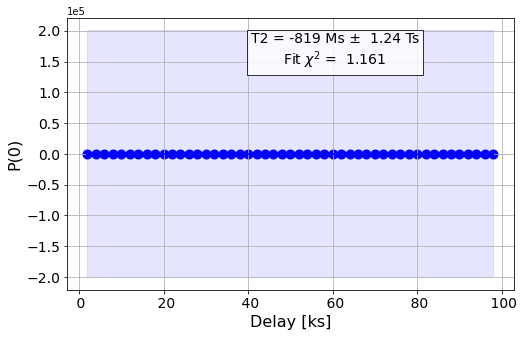

In [39]:
p0 = {
    "A": [0.5],
    "T2star": [20000],
    "B": [0.5],
}
backend_in_ns = T2HahnBackend(
    t2hahn=[20],
    frequency=[100100],
    initialization_error=[0.0],
    readout0to1=[0.02],
    readout1to0=[0.02],
    conversion_factor=conversion_factor,
)
exp_in_ns = T2Hahn(qubit, delays2, unit=unit)
user_p0_ns = {
    "A": 0.5,
    "T2": 20000.0,
    "B": 0.5
}
exp_in_ns.set_analysis_options(p0=user_p0_ns)

# Run experiment
expdata_in_ns = exp_in_ns.run(backend=backend_in_ns, shots=2000).block_for_results()

# Display Figure
display(expdata_in_ns.figure(0))

In [ ]:
# Print Results
for result in expdata_in_ns.analysis_results():
    print(result)

In [ ]:
import qiskit.tools.jupyter
%qiskit_copyright